# Сборный проект

<font size = +2>Исследование стартапа продуктов питания</font>

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. 

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
import math as mth

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
logs.info()
logs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Получили датасет из 244126 записей, с названием события, айди устройства, временем события и номером эксперимента.

## Предобработка данных

In [4]:
logs.columns=['event_name', 'device_id', 'event_timestamp', 'exp_id']

In [5]:
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'],unit='s')

In [6]:
logs.head(5)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [7]:
logs.duplicated().sum()

413

In [8]:
logs.duplicated().sum() / len(logs) * 100

0.16917493425526162

Дубликаты составляют всего 0.17% от всего датасета. Их можно удалить.

In [9]:
logs = logs.drop_duplicates()

In [10]:
logs.isna().sum()

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков нет.

In [11]:
logs.loc[:,'date'] = logs.loc[:,'event_timestamp'].dt.date

## Исследовательский анализ данных

In [12]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id        243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [13]:
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Всего существует 5 уникальных событий - MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial.

In [14]:
logs['device_id'].nunique()

7551

In [15]:
len(logs)

243713

7551 уникальных пользователей в датасете.

In [16]:
logs.groupby('device_id')['event_name'].count().mean()

32.27559263673685

~32 уникальных события на пользователя

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-10.0, 150.0)

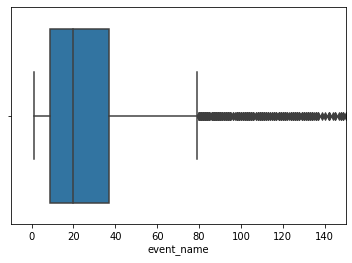

In [17]:
g = logs.groupby('device_id')['event_name'].count()
sns.boxplot(g)
plt.xlim(-10,150)

20 уникальных событий на пользователя по медиане, 90% пользователей совершили от 0 до 80 событий за период наблюдений.

In [18]:
display(
logs['date'].min(),
logs['date'].max(),
logs['date'].max() - 
logs['date'].min()
)

datetime.date(2019, 7, 25)

datetime.date(2019, 8, 7)

datetime.timedelta(days=13)

Данные с 25 июля 2019 года по 7 августа, 13 дней.

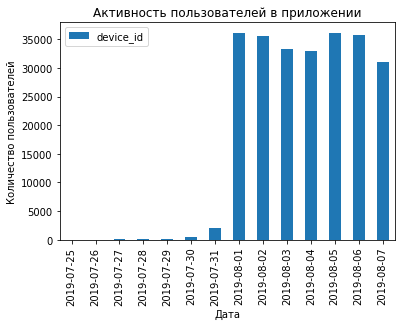

In [19]:
g = logs.groupby('date').agg({'device_id':'count'}).reset_index()
g.plot(kind='bar', x='date')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Активность пользователей в приложении');

In [20]:
#g.hist(x='date')

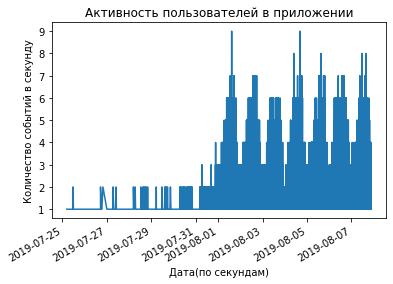

In [21]:
g = logs.groupby('event_timestamp')['event_name'].count()
g.plot()
plt.ylabel('Количество событий в секунду')
plt.xlabel('Дата(по секундам)')
plt.title('Активность пользователей в приложении');

In [22]:
logs.query('event_timestamp in ["2019-07-31","2019-08-01"]')

,event_name,device_id,event_timestamp,exp_id,date


In [23]:
logs.query('date == "2019-07-31"')

,event_name,device_id,event_timestamp,exp_id,date


(18108, 18110)

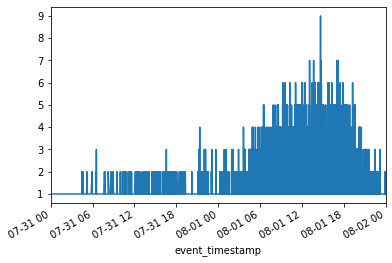

In [24]:
g.plot()
plt.xticks()
plt.xlim(18108,18110)

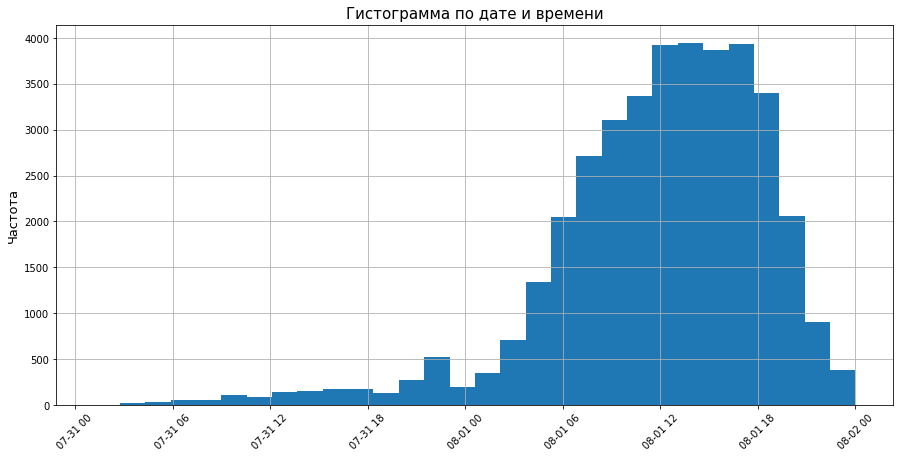

In [25]:
df1 = logs[logs['event_timestamp'].dt.strftime('%Y-%m-%d') >= '2019-07-31'] 
df1 = df1[df1['event_timestamp'].dt.strftime('%Y-%m-%d') <= '2019-08-01'] 
ax = df1['event_timestamp'].hist(figsize=(15,7),bins = 30)
plt.title('Гистограмма по дате и времени', size = 15)
plt.ylabel('Частота', size = 13)
plt.xticks(rotation=45)
plt.show()

Полные данные есть только с первого августа.

In [26]:
logs.query('event_timestamp < "2019-08-01"')['event_name'].count() / logs['event_name'].count() * 100

1.159560630741897

Данные за период с 25 июля по 1 августа составляют всего 1.15% от датасета.

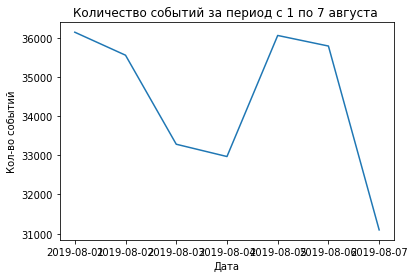

In [27]:
logs = logs.query('event_timestamp >= "2019-08-01"')
logs.groupby('date')['event_name'].count().plot()
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Количество событий за период с 1 по 7 августа ');

Откинули данные до 1 августа. Остался период с 1го по 7е августа включительно.

In [28]:
logs.groupby('exp_id').agg({'device_id':'nunique'})

,device_id
exp_id,
246,2484
247,2513
248,2537


Есть пользователи из всех экспериментальных групп.

### Вывод

Всего существует 5 уникальных событий - MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial. 7551 уникальных пользователей в датасете. ~32 уникальных события на пользователя. Минимальная дата датасета 25 июля, максимальная 7 августа 2019 года. Данные с 25 июля по 1 августа были скудными, и составляли всего 1.15% датасета, отбросив их мы получили датасет с 1 по 7 августа в котором присутствовали все группы пользователей.

## Воронки событий

event_timestamp
2019-07-25 04:43:36    1
2019-07-25 11:11:42    1
2019-07-25 11:28:47    2
2019-07-25 11:48:42    1
2019-07-25 11:48:43    1
                      ..
2019-08-07 21:12:25    1
2019-08-07 21:13:59    1
2019-08-07 21:14:43    1
2019-08-07 21:14:58    1
2019-08-07 21:15:17    1
Name: event_name, Length: 176654, dtype: int64

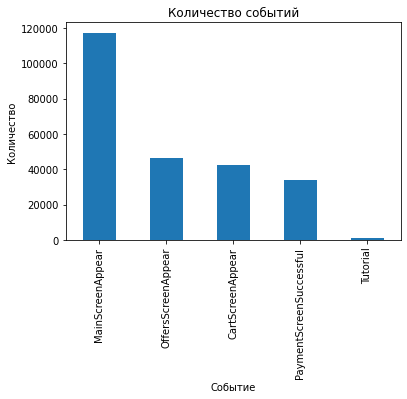

In [29]:
logs.groupby('event_name')['event_name'].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Количество событий')
plt.xlabel('Событие')
plt.ylabel('Количество')
g

In [30]:
(logs.groupby('device_id')['event_name'].nunique() == 5).sum()

466

Только 466 пользователей совершили все события.

Доля пользователей которые совершили хоть одно действие.

100%

In [32]:
logs['event_name'].isna().sum()

0

Скорее всего, события идут в таком порядке MainScreenAppear > OffersScreenAppear > CastScreenAppear > PaymentScreenSuccessful > Tutorial.

Мы полагаем, что событие Tutorial не важное для нас, так как происходит уже после оплаты и, скорее всего, не обязательное.

In [33]:
funnel.drop(4, inplace=True)

Также, можно предположить, что оплатить заказ возможно не открывая корзины, поскольку число открытий корзины и оплаты примерно одинаковое.

In [34]:
funnel['percentage'] = round(funnel['device_id'] / funnel['device_id'].shift(1) * 100, 2)
funnel

,event_name,device_id,percentage
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


In [1]:
fig = go.Figure(go.Funnel(
    x = funnel['device_id'],
    y = funnel['event_name'],
    textinfo = "value+percent initial+percent previous",
    hoverinfo = "percent previous"))

fig.update_layout(
    title={
        'text': "Воронка всех событий",
        'xanchor': 'left',
        'yanchor': 'bottom'})

fig.show()

NameError: name 'go' is not defined

Так будет выглядеть воронка, если мы считаем событие PaymentScreenSuccessful зависимым от CartScreenAppear.

In [36]:
funnel_1 = funnel.drop(3, axis=0)
funnel_2 = funnel.drop(2, axis=0)

In [37]:
fig = go.Figure(go.Funnel(
    x = funnel_1['device_id'],
    y = funnel_1['event_name'],
    textinfo = "value+percent initial+percent previous",
    hoverinfo = "percent previous"))

fig.update_layout(
    title={
        'text': "Воронка 1",
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In [38]:
fig = go.Figure(go.Funnel(
    x = funnel_2['device_id'],
    y = funnel_2['event_name'],
    textinfo = "value+percent initial+percent previous",
    hoverinfo = "percent previous"))

fig.update_layout(
    title={
        'text': "Воронка 2",
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Вот так бдут выглядеть воронки, если мы считаем события CartScreenAppear и PaymentScreenSuccessful независимыми.

Больше всего пользователей теряется на 2 шаге MainScreenAppear > OffersScreenAppear.

In [39]:
round(funnel['device_id'][3] / funnel['device_id'][0] * 100, 2)

47.7

Только 47.7 процентов пользователей доходят от первого события до оплаты.

### Вывод

Мы проанализировали события и выявили несколько возможных воронок продаж. У всех воронок продаж от первого события(показа главного экрана приложения) до оплаты доходят 47.7% пользователей.

## Анализ экспериментов

Для анализа наших экспериментов будем использовать коэффициент значимости a = 0.05

In [40]:
alpha = 0.05

In [41]:
logs.groupby('exp_id')['device_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

У нас есть 3 экспериментальных группы, в каждой по ~2500 человек.

Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [42]:
(1 - 2484/2513) * 100

1.1539992041384783

Размеры выборок отличаются на 1.15%. В идеале - количество не должно различаться больше чем на 1 процент.

Нулевая гипотеза - группы 246 и 247 одинаковые. Альтернативная гипотеза - группы 246 и 247 разные.

In [43]:
def significance(group1, group2, event):
    successes = np.array([logs.query('(exp_id in @group1) & (event_name == @event)')['device_id'].nunique(),
                     logs.query('(exp_id in @group2) & (event_name == @event)')['device_id'].nunique()])
    trials = np.array([logs.query('exp_id in @group1')['device_id'].nunique(),
                  logs.query('exp_id in @group2')['device_id'].nunique(),])

# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
# разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Проверяли гипотезу о равенстве числа пользователей совершивших событие {event} в группах {group1} и {group2}')
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
        )
    print()

significance([246], [247], "PaymentScreenSuccessful")

Проверяли гипотезу о равенстве числа пользователей совершивших событие PaymentScreenSuccessful в группах [246] и [247]
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



A/A тест показал что группы одинаковые.

In [44]:
logs['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [45]:
significance([246], [248], "PaymentScreenSuccessful")
significance([246], [248], "Tutorial")
significance([246], [248], "MainScreenAppear")
significance([246], [248], "OffersScreenAppear")
significance([246], [248], "CartScreenAppear")

significance([247], [248], "PaymentScreenSuccessful")
significance([247], [248], "Tutorial")
significance([247], [248], "MainScreenAppear")
significance([247], [248], "OffersScreenAppear")
significance([247], [248], "CartScreenAppear")

#significance((246 & 247), 248)

Проверяли гипотезу о равенстве числа пользователей совершивших событие PaymentScreenSuccessful в группах [246] и [248]
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие Tutorial в группах [246] и [248]
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие MainScreenAppear в группах [246] и [248]
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие OffersScreenAppear в группах [246] и [248]
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие CartScreenAppear в группах 

Во всех экспериментах p-value > alpha, следовательно мы не можем считать статистически значимой разницу между группами.

In [46]:
significance([246, 247], [248], "PaymentScreenSuccessful")
significance([246, 247], [248], "Tutorial")
significance([246, 247], [248], "MainScreenAppear")
significance([246, 247], [248], "OffersScreenAppear")
significance([246, 247], [248], "CartScreenAppear")

Проверяли гипотезу о равенстве числа пользователей совершивших событие PaymentScreenSuccessful в группах [246, 247] и [248]
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие Tutorial в группах [246, 247] и [248]
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие MainScreenAppear в группах [246, 247] и [248]
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие OffersScreenAppear в группах [246, 247] и [248]
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверяли гипотезу о равенстве числа пользователей совершивших событие CartScr

### Вывод

Мы не нашли статистически значимой разницы между экспериментальной группой 248 и контрольными группами 246 и 247, как по отдельности, так и между 248 и объединенными 246 и 247, по любым событиям. Alpha = 0.05.

## Общий вывод

В этом проекте мы проанализировали результаты внедрения новых шрифтов. Для этого, мы выполнили загрузку и предобработку датасета, полученного от заказчика. Провели исследовательский анализ данных, в результате которого мы отсекли "пустую" неделю в датасете с 25 по 31 июля, в общей сложности 1.15% событий. Мы определили, что средний пользователь приложения совершает, в среднем 20 событий в неделю, а 90% пользователей совершают от 0 до 80 событий в неделю. Мы проанализировали воронки событий, и нашли что 48% пользователей совершают заказ пользуясь приложением.

Мы исследовали результаты A/B тестов, проведенных на трех группах 246, 247 и 248. Всего мы провели 15 проверок гипотез. Основываясь на результатах статистического анализа, нет оснований предполагать что шрифты влияют на поведение пользователей.

Рекомендуем шрифты не менять, изменения откатить.